# Final Project: Identifying Penguin Species with Machine Learning
Registration number: 2322761

## Introduction
In this project I will develop a machine learning model that can be used to identify different species of penguin given various attributes. I will compare the performance of using a decision tree versus a random forest and K-nearest neighbours, and in order to train and test the model, I will be using the penguins dataset by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, which can be downloaded from Kaggle [here](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data) (1).

The motivation for using AI in this context is that if more data regarding penguins were collected in this area but the particular species were unknown, it would be possible to categorise them using the models, and comparing various models enables us to find the most accurate and efficient one. This could occur if, for example, the penguins themselves are not visible and only some of the attributes could be identified, such as flipper length from fossils and footprints, or perhaps the culmen length from skeletons that were found in the area. Furthermore, if there were data that were collected without the species label, it would also not only be difficult, but costly to travel to Antartica to collect the data again given the challenging climate. Having a machine learning model therefore provides an easy, cost-effective approach to categorise penguin species if we have other information about them already.

### Exploratory Data Analysis

Before we can train the models, we first need to carry out an exploratory data analysis to get a better overview of the data, and then clean the data as necessary.

#### General Overview

In [1]:
import pandas as pd
import numpy as np

#read in dataset (please replace path with your relevant path)
penguins = pd.read_csv("C:/Users/anntr/OneDrive/Documents/Essex Uni/MA336_Artificial_Intelligence_and_Machine_Learning_with_Applications/FinalProject/penguins_lter.csv")

#show information about the penguins dataframe
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studyName            344 non-null    object 
 1   Sample Number        344 non-null    int64  
 2   Species              344 non-null    object 
 3   Region               344 non-null    object 
 4   Island               344 non-null    object 
 5   Stage                344 non-null    object 
 6   Individual ID        344 non-null    object 
 7   Clutch Completion    344 non-null    object 
 8   Date Egg             344 non-null    object 
 9   Culmen Length (mm)   342 non-null    float64
 10  Culmen Depth (mm)    342 non-null    float64
 11  Flipper Length (mm)  342 non-null    float64
 12  Body Mass (g)        342 non-null    float64
 13  Sex                  334 non-null    object 
 14  Delta 15 N (o/oo)    330 non-null    float64
 15  Delta 13 C (o/oo)    331 non-null    flo

As shown above, the dataframe gives information for 344 observations on 16 variables.  In terms of qualitative variables, we have the study name, species, region, island, stage, individual ID, clutch completion (whether or not the study nest was observed with a full clutch, i.e., 2 eggs), sex, and comments. In terms of continuous data, we have the date (of) egg, culmen length (mm), culmen depth (mm), flipper length (mm), body mass (g), delta 15 N (a number denoting the measure of the ratio of stable isotopes 15N:14N), and delta 13 C (a number denoting the measure of the ratio of stable isotopes 13C:12C). Below are some of the unqiue values for each variable.

In [2]:
#List the unique values for each variable
pd.Series({c: penguins[c].unique() for c in penguins})

studyName                                    [PAL0708, PAL0809, PAL0910]
Sample Number          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
Species                [Adelie Penguin (Pygoscelis adeliae), Chinstra...
Region                                                          [Anvers]
Island                                        [Torgersen, Biscoe, Dream]
Stage                                               [Adult, 1 Egg Stage]
Individual ID          [N1A1, N1A2, N2A1, N2A2, N3A1, N3A2, N4A1, N4A...
Clutch Completion                                              [Yes, No]
Date Egg               [11/11/07, 11/16/07, 11/15/07, 11/9/07, 11/12/...
Culmen Length (mm)     [39.1, 39.5, 40.3, nan, 36.7, 39.3, 38.9, 39.2...
Culmen Depth (mm)      [18.7, 17.4, 18.0, nan, 19.3, 20.6, 17.8, 19.6...
Flipper Length (mm)    [181.0, 186.0, 195.0, nan, 193.0, 190.0, 180.0...
Body Mass (g)          [3750.0, 3800.0, 3250.0, nan, 3450.0, 3650.0, ...
Sex                                               [

#### Frequency of penguins by species and gender
Next, visualising the data enables us to get a clearer picture for feature selection, that is, "the process of isolating the most consistent, non-redundant, and relevant features to use in model construction" (3).The bar chart below shows the frequency of penguins by species and gender.

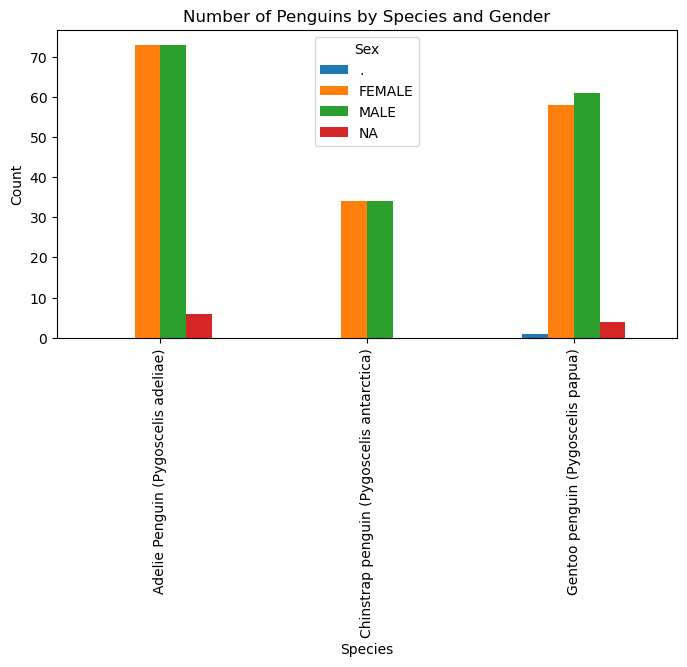

In [3]:
import matplotlib.pyplot as plt

# Create a crosstab of species and sex
species_gender_counts = pd.crosstab(penguins['Species'], penguins['Sex'])

# Count NA values in the 'Sex' column
na_counts = penguins[penguins['Sex'].isna()].groupby('Species').size()

# Add the NA counts to the crosstab
species_gender_counts['NA'] = na_counts

# Replace NaN values with 0 for plotting purposes
species_gender_counts = species_gender_counts.fillna(0)

# Plot the data
species_gender_counts.plot(kind='bar', figsize=(8, 4))
plt.title('Number of Penguins by Species and Gender')
plt.xlabel('Species')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.show()


The bar chart shows that there is a relatively even distribution of male and female penguiuns across the different species, however, it shows that there is an uneven distribution of the different species themselves, with the Adelie penguin species being the most common species of penguin in the dataset with around 150 in total. In contrast, the Chinstrap penguin is the least common species, with just less than half the number compared to Adelie penguins. This may cause an issue for the classification process, as it could lead to bias towards the Adelie penguin species and poor performance for the Chinstrap penguin. Later in this report I will identify methods to handle any bias that may arise from this imbalance.

Additionally, the bar chart shows that there is a relatively small number of NA values or values labeled '.' in regards to the sex, and are not specific to one species. This indicates that the NA values can be simply removed, as there is an insignificant number and do not imply that it is hard to identify the sex of a particular species, which could have been a possible indicator of the species. 

#### Penguin species by island

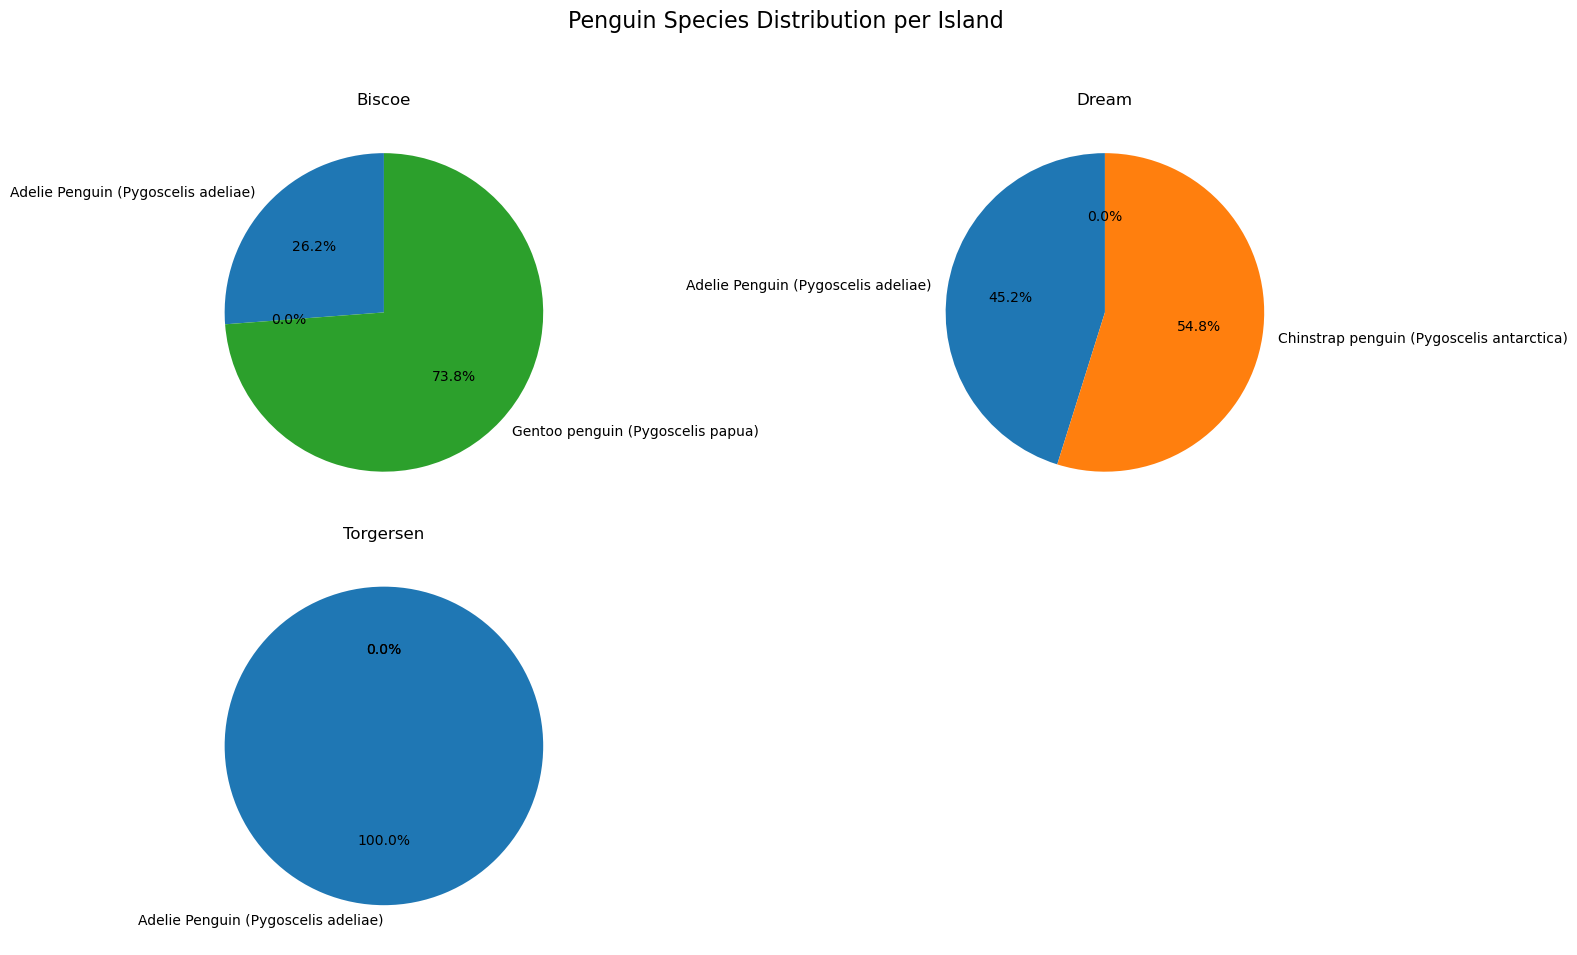

In [4]:
#Pie charts of penguin species by island

#Group species per island
species_per_island = penguins.groupby(['Island', 'Species']).size().unstack(fill_value=0)

# Set the figure size
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create a pie chart for each island
for i, (island, counts) in enumerate(species_per_island.iterrows()):
    ax = axes[i]
    counts.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90, legend=False)
    ax.set_ylabel('')
    ax.set_title(island)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add title
plt.suptitle('Penguin Species Distribution per Island', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 

# Show the plot
plt.show()

The pie charts show the distribution of penguin species by island. They show that Gentoo penguins are only found on the Biscoe island, and that Chinstrap penguins are only found on the Dream island. Adelie penguins can be found on all three islands, however, and are the only penguin species present on the Torgersen island according to the dataset. As shown in the general overview of the dataset, there were no NA values present in island or species variables, and so all of this shows that the specific island is a significant indicator of penguin species.

#### Culmen length and culmen depth

As culmen length and culmen depth are quite similar variables, I have grouped them together to put on a scattergraph to see if there is a relation between culmen length, depth and penguin species. For clarification, the culmen is defined as "the external ridge on the upper mandible of a bird's bill" (2).

<__array_function__ internals>:200: UserWarning: Warning: converting a masked element to nan.
C:\Users\anntr\anaconda3\Lib\site-packages\matplotlib\colors.py:1325: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
C:\Users\anntr\anaconda3\Lib\site-packages\matplotlib\ticker.py:525: UserWarning: Warning: converting a masked element to nan.
  else fmt % arg)


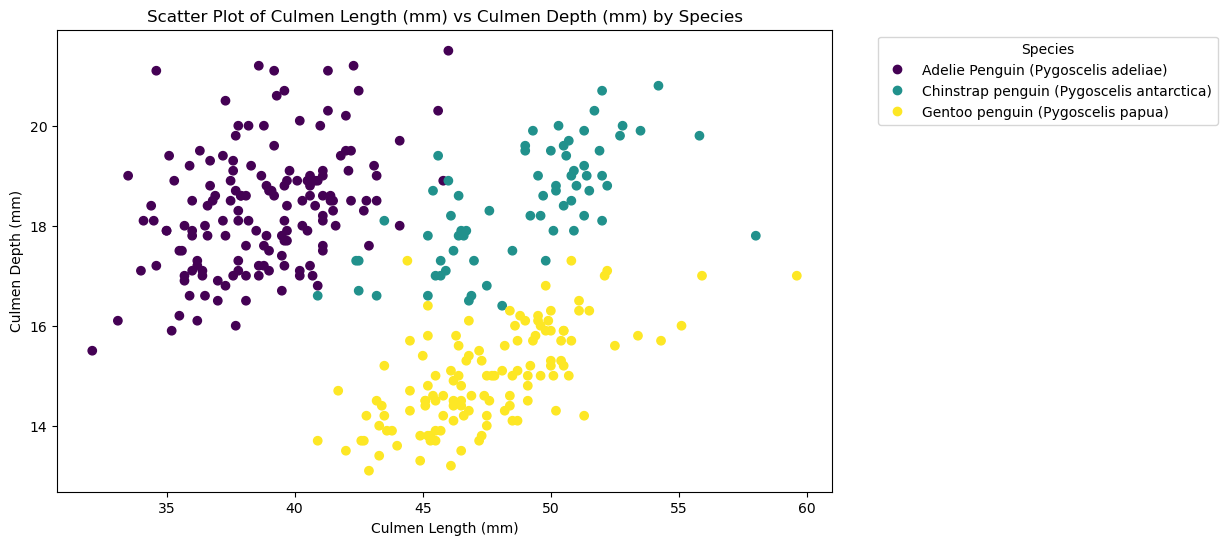

In [5]:
# Scatter plot for culmen length and depth coloured by species
x_var = 'Culmen Length (mm)'
y_var = 'Culmen Depth (mm)'
colour_var = 'Species'

plt.figure(figsize=(10, 6))
scatter = plt.scatter(penguins[x_var], penguins[y_var], 
                      c=penguins[colour_var].astype('category').cat.codes, cmap='viridis')

# Add labels and title
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.title('Scatter Plot of Culmen Length (mm) vs Culmen Depth (mm) by Species')

# Add legend
handles, labels = scatter.legend_elements()
legend_labels = penguins[colour_var].astype('category').cat.categories
plt.legend(handles, legend_labels, title=colour_var, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

The scatter plot also shows a relationship between both the length and depth of the culmen and the penguin species. Generally, the Adelie penguin species has a short, deep culmen (approximately 31-45mm long and 16-22mm deep); the Chinstrap penguin species has a long, deep culmen (approximately 42-56mm long and 16-21mm deep); and the Gentoo penguin species generally have long, shallower culmens (approximately 41-60mm long and 13-17mm deep). Evidently, there exists some overlap between the different species, and so care must be taken to avoid overfitting for these variables especially.

#### Body mass and flipper length

Similarly, a scatter plot of the body mass and flipper length was plotted to investigate if these may be used as indicators for species. These were grouped together as it may be assumed that the longer the flipper length, the larger the body mass.  The scatter plot for these variables can be seen below.

<__array_function__ internals>:200: UserWarning: Warning: converting a masked element to nan.
C:\Users\anntr\anaconda3\Lib\site-packages\matplotlib\colors.py:1325: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
C:\Users\anntr\anaconda3\Lib\site-packages\matplotlib\ticker.py:525: UserWarning: Warning: converting a masked element to nan.
  else fmt % arg)


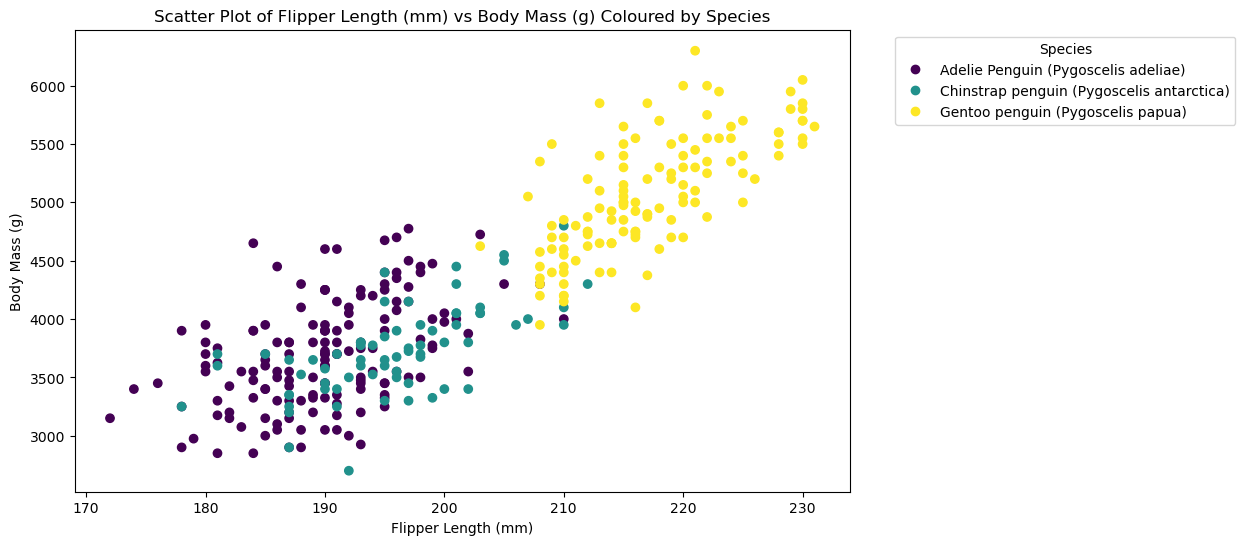

In [6]:
# Scatter plot for culmen length and depth coloured by species
x_var2 = 'Flipper Length (mm)'
y_var2 = 'Body Mass (g)'
colour_var = 'Species'

plt.figure(figsize=(10, 6))
scatter = plt.scatter(penguins[x_var2], penguins[y_var2], 
                      c=penguins[colour_var].astype('category').cat.codes, cmap='viridis')

# Add labels and title
plt.xlabel(x_var2)
plt.ylabel(y_var2)
plt.title('Scatter Plot of Flipper Length (mm) vs Body Mass (g) Coloured by Species')

# Add legend
handles, labels = scatter.legend_elements()
legend_labels = penguins[colour_var].astype('category').cat.categories
plt.legend(handles, legend_labels, title=colour_var, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

This plot shows that in terms of the flipper length and body mass, Adelie penguins and Chinstrap penguins are almost indistinguishable, with flipper lengths for Adelie penguins ranging from around 172mm-210mm compared to around 177mm-211mm for the Chinstrap penguins, and body mass for both species ranging from around 3200g-4800g. In contrast, both the flipper length and body mass are larger for the Gentoo penguin species compared to the other species, with a flipper length ranging from around 203mm-230mm and a body mass ranging from around 3900g-6300g. This implies that while body mass and flipper length may not be useful in distinguishing between the Adelie species and Chinstrap species, they are useful in distinguishing between these species and Gentoo penguins.

### Data Cleansing

From the above exploratory data analysis, it was shown that the island, culmen length, culmen depth, flipper length, and body mass variables can all help determine the species of penguin.  The variables study name, sample number, region, stage, individual ID, clutch completion, date egg, sex, and comments, will be dropped as they do not help in identifying penguin species as they are more specific to this dataset or do not give any extra information. The variables 'delta 15 N' and 'delta 13 C' will also be dropped as these variables require more specific domain knowledge and are not neccessary for the purpose of this report. 

As seen from the outputs above, NA values also need to be dealt with. For this report, I will simply remove observations containing an NA value, as the NA values are small in number and the other data should be sufficient to train the models.

The first few entries of the updated dataframe are shown below.

In [7]:
#Remove the unnessary columns
penguins = penguins.drop(['studyName', 'Sample Number', 'Region','Stage','Individual ID', 
                          'Clutch Completion', 'Date Egg', 'Sex', 'Delta 15 N (o/oo)', 
                          'Delta 13 C (o/oo)', 'Comments'], axis=1)

#Remove N/A values
penguins = penguins.dropna(axis=0, how='any')

#Show the top few entries
penguins.head()

Species     Island  Culmen Length (mm)  \
0  Adelie Penguin (Pygoscelis adeliae)  Torgersen                39.1   
1  Adelie Penguin (Pygoscelis adeliae)  Torgersen                39.5   
2  Adelie Penguin (Pygoscelis adeliae)  Torgersen                40.3   
4  Adelie Penguin (Pygoscelis adeliae)  Torgersen                36.7   
5  Adelie Penguin (Pygoscelis adeliae)  Torgersen                39.3   

   Culmen Depth (mm)  Flipper Length (mm)  Body Mass (g)  
0               18.7                181.0         3750.0  
1               17.4                186.0         3800.0  
2               18.0                195.0         3250.0  
4               19.3                193.0         3450.0  
5               20.6                190.0         3650.0

In [8]:
#Show the new dataframe length
print("New dataframe length: ", len(penguins))
print("(Original dataframe length: 344)")

New dataframe length:  342
(Original dataframe length: 344)


Next, before we can put the data into the models, any categorical variables (i.e. species, island) must first be converted into numerical data:

In [9]:
#Show all penguin species
penguins.Species.unique()

array(['Adelie Penguin (Pygoscelis adeliae)',
       'Chinstrap penguin (Pygoscelis antarctica)',
       'Gentoo penguin (Pygoscelis papua)'], dtype=object)

In [10]:
#Convert categorical data to numerical data
penguins['Island']=penguins['Island'].map({'Torgersen' : 0, 'Biscoe' : 1, 'Dream' : 2})
penguins['Species']=penguins['Species'].map({'Adelie Penguin (Pygoscelis adeliae)' : 0, 
                                             'Chinstrap penguin (Pygoscelis antarctica)' : 1, 
                                             'Gentoo penguin (Pygoscelis papua)' : 2})

penguins.head(20)

Species  Island  Culmen Length (mm)  Culmen Depth (mm)  \
0         0       0                39.1               18.7   
1         0       0                39.5               17.4   
2         0       0                40.3               18.0   
4         0       0                36.7               19.3   
5         0       0                39.3               20.6   
6         0       0                38.9               17.8   
7         0       0                39.2               19.6   
8         0       0                34.1               18.1   
9         0       0                42.0               20.2   
10        0       0                37.8               17.1   
11        0       0                37.8               17.3   
12        0       0                41.1               17.6   
13        0       0                38.6               21.2   
14        0       0                34.6               21.1   
15        0       0                36.6               17.8   
16        0       0                38.7               19.0   
17        0       0                42.5               20.7   
18        0       0                34.4               18.4   
19        0       0                46.0               21.5   
20        0       1                37.8               18.3   

    Flipper Length (mm)  Body Mass (g)  
0                 181.0         3750.0  
1                 186.0         3800.0  
2                 195.0         3250.0  
4                 193.0         3450.0  
5                 190.0         3650.0  
6                 181.0         3625.0  
7                 195.0         4675.0  
8                 193.0         3475.0  
9                 190.0         4250.0  
10                186.0         3300.0  
11                180.0         3700.0  
12                182.0         3200.0  
13                191.0         3800.0  
14                198.0         4400.0  
15                185.0         3700.0  
16                195.0         3450.0  
17                197.0         4500.0  
18                184.0         3325.0  
19                194.0         4200.0  
20                174.0         3400.0

## Methods: Random Classifier, Decision Trees, Random Forests and K-Nearest Neighbours

### Random Classifier

Before investigating the performances of different AI methods, I will first use a random classifier. This will provide a simple baseline for comparison for the other methods.


### Decision Trees

The first ML method I have chosen to identify penguin species is to use a decision tree, as we have labelled data meaning we need a supervised learning algorithm. As there are several attributes of different data types which are being used, this algorithm is also the simplest to implement and therfore comprehend, which may be useful if it is to be used by the general public who may not have an understanding for other algorithms. Furthermore, unlike algorithms such as naïve Bayes, it does not require any assumptions to be made for the model to work effectively (4).

Decison trees have a flowchart-like structure which can be used to make predictions (in this case the species of penguin). They  consist of a root node and internal nodes, and work by narrowing down the data using the best attribute to split the data until a final decision is made in what is called the leaf node. To optimise the split at each node, I will use be using Gini Impurity as the metric to determine the split. This is a measure of impurity, or more specifically, measures the degree or probability of a particular variable being wrongly classified when it is randomly chosen. When all cases in the node fall into a single category, the Gini Impurity is zero. It is calculated using the following formula:

$$
\text{Gini} = 1 - \sum_{i=1}^{n} (p_i)^2, \quad \text{where } p_i \text{ is the probability of an instance being classified into a particular class (4).}
$$

To train the algorithm, I will first split the data into a training set and test set using the hold-out cross-validation. This is where a proportion of the data is used as the training data, and the other proportion is used as the test data. Like decision trees, this method is simple to implement and comprehend, and allows for stratification which is important given the uneven classes of the species in the dataset.

As one of the key disadvantages of decision trees is that it is prone to overfitting (5), I will also use k-fold cross-validation to check if this is the case. Overfitting is where an algorithm performs well on the training set of data, however, perform poorly when used on a different sample or other dataset, as it is taking account the noise and peculiarities of the training data. K-fold cross-validation can help identify this as it divides the data into k equal sets, and trains and evaluates the model k times, using a different fold for the test set each time, and the mean performance over k metrics is then calculated.

### Random Forests

After developing the decision tree, I will use random forests to see if I can get a better model, as this is another way to combat overfitting in decision trees in case the k-fold cross-validation shows that this is present in the algorithm.  Random forests are simply many decision trees which choose a random subset of features to improve accuracy and reduce bias, as it ensures a low correlation among its decision trees (6). The mode classification is then used to determine the predicted outcome of an observation. For this algorithm I will use bootstrap sampling (sampling with replacement), which is said to yield a more accurate estimate and reduce variance within a noisy dataset (6).

### K-Nearest Neighbours (KNN)

The decision tree and random forest are relatively similar algorithms, and so it would be interesting to see how they compare to K-Nearest Neighbours. This is also a supervised learning algorithm, and also relatively simple. In this algorithm, it uses proximity to make classifications, following the assumption that similar points can be found near one another (7). When developing this algorithm, I will use k-fold cross-validation to determine the best value for k (i.e. the number of 'neighbours' the algorithm needs to classify a point). This is to prevent underfitting or overfitting the algorithm, which I will go into more detail later.

## Results

### Random Classifier

In [11]:
#Defining the input variables
features=penguins.drop(['Species'],axis=1)

# Target variable
species_label = penguins['Species'] 

In [12]:
import numpy as np
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="uniform", random_state=5)
dummy_clf.fit(features, species_label)
dummy_clf.predict(features)
dummy_clf.score(features, species_label)

0.37719298245614036

In the above code I used the "uniform" strategy from sklearn's Dummy Classifier, which randomly selects a class with equal probability. Using a random classifier gives an average accuracy of 37.7%, meaning less than half of the observations were classified correctly.

### Creating the Decision Tree and Testing Accuracy using Hold-out Cross-Validation

In [13]:
## Splitting the data into the training set and test datasets

from sklearn.model_selection import train_test_split

#Defining the input variables
features=penguins.drop(['Species'],axis=1)

# Target variable
species_label = penguins['Species'] 

species_label_names=['Adelie Penguin',
       'Chinstrap penguin',
       'Gentoo penguin'] 

#Make 75% of the data the training set and the rest the test set.
features_train, features_test, species_label_train, 
species_label_test = train_test_split(features, species_label,
                                      test_size=0.25, 
                                      random_state=5, 
                                      stratify=species_label)

print("Training set inputs (rows, columns): ", features_train.shape)
print("Test set inputs (rows, columns): ", features_test.shape)
print("Training set targets (rows): ", species_label_train.shape)
print("Test set targets (rows): ", species_label_test.shape)

NameError: name 'features_train' is not defined

The above code has split the 75% of the data into the training set and 25% of the data into the test set: altogether, 256 observations on the 5 different features are in the training set with 256 species labels, and 86 observations on the 5 different features have been put into the test set, with the corresponding 86 species labels. In the above code the data has been stratified, meaning that it has been split so that there is a similar proportion of each species in both the training set and test set which, as mentioned in the method section, is important given the uneven distribution of species in the dataset.  This makes sure that some species are not over- or underrespresented in the training or test set.

Next, it is important to determine the max depth that the decision tree should take to prevent overfitting. In the below plot various values for the maximum depth hyperparameter were used, and the accuracy of each one for the training set and test set is shown.

In [ ]:
#Show accuracies for different tree depths

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Initialize lists to store accuracies
train_accuracies = []
test_accuracies = []

# Define the range of max_depth values to iterate over
max_depth_range = range(1, 10)

# Loop over different values of max_depth
for max_depth in max_depth_range:
    # Initialize and train the decision tree classifier
    decision_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=5)
    decision_tree.fit(features_train, species_label_train)
    
    # Predict on training and test sets
    train_predictions = decision_tree.predict(features_train)
    test_predictions = decision_tree.predict(features_test)
    
    # Calculate accuracy for both sets
    train_accuracy = accuracy_score(species_label_train, train_predictions)
    test_accuracy = accuracy_score(species_label_test, test_predictions)
    
    # Append accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(max_depth_range, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. max_depth for Decision Tree')
plt.legend()
plt.grid(True)
plt.show()

According to the graph, the optimal maximum depth is around 3. This is because at this depth, the test accuracy is very high but plateaus after this point, indicating that an increased complexity in the model does not significantly improve performance on the test data. 

In [ ]:
#Create the decision tree
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier(max_depth = 3, random_state=5) 
decision_tree.fit(features_train, species_label_train)
species_label_pred = decision_tree.predict(features_test)

#Visualise the decision tree
from matplotlib import pyplot as plt

Features_list = penguins.columns.tolist() # Make a list of the feature names
Feature_names = Features_list[1:] # Remove 'Species' from feature names

fig = plt.figure(figsize=(30,20))
_ = tree.plot_tree(decision_tree,
                   feature_names=Feature_names,
                   class_names=species_label_names,
                   filled=True,
                   proportion=False,
                   fontsize=18) 

In [ ]:
from sklearn import metrics

# Print the model accuracy
print("Accuracy on test set:",np.round(metrics.accuracy_score(species_label_test, species_label_pred),2))

Using a maxinmum depth of 3, we get a very high accuracy of 99%. This is much higher than the random classifier which achieved an accuracy of 37.7%. However, as shown in the graph, there are a small number of samples in some of the leaf nodes which may be a sign of overfitting. To check, I will use K-Fold cross validation to ensure that the accuracy is not to do with the particular training set and test set from above.

#### Accuracy using K-Fold Cross Validation

In [ ]:
import math

# Use 5-fold cross-validation to compute the mean accuracy at a tree depth of 3
from sklearn.model_selection import cross_val_score
maxDepth = 3
k=5
decision_tree = tree.DecisionTreeClassifier(max_depth=maxDepth, random_state=2)
cv_scores = cross_val_score(decision_tree, features, species_label, cv=k)
print('Cross-validation scores are:',cv_scores)

# Compute the average and standard deviations of the accuracies 
avg = sum(cv_scores)/len(cv_scores)
sd = math.sqrt(sum((cv_scores-avg)**2)/(len(cv_scores)-1))
print('Average performance for a tree depth of',maxDepth,'is:',
      np.round(avg*100,1),'+/-',np.round(sd*100,1),'%')

In the above code I used the cross_val_score function from sklearn.model_selection, which by default performs stratified k-fold cross-validation, ensuring that the class distribution in each fold is similar to that of the entire dataset. The output gives a slightly lower average accuracy of 96.5%, suggesting that the high accuracy in the tree above was just due to the particular training and test dataset. Nevertheless, the accuracy is still relatively high, but creating a random forest will help indicate whether there is overfitting.

### Comparison to Random Forest

The code to develop the random forest is shown below, using the same max depth as the decision tree above. 

In [ ]:
#Create the random forest
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100,
                                bootstrap=True,
                                max_features='sqrt',
                                criterion='gini',
                                max_depth=3,
                                random_state=5,
                                oob_score=True)

forest.fit(features_train, species_label_train)
species_label_train_pred = forest.predict(features_train)

#Print accuracies
print("Accuracy on training set:",
      round(metrics.accuracy_score(species_label_train, species_label_train_pred),2))
species_label_test_pred = forest.predict(features_test)
print("Accuracy on test set:",
      round(metrics.accuracy_score(species_label_test, species_label_test_pred),2))
print("OOB score:",round(forest.oob_score_,2))

# Cross-Validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(forest, features, species_label, cv=5)
print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', np.mean(cv_scores))

Unsurprisingly, when comparing the accuracy of the random forest to the accuracy of the decision tree which used k-fold cross-validation, the accuracy of the random forest is higher, with an accuracy of 98.2% compared to the accuracy of 96.5% for the individual decision tree. This is because they produce a more stable prediction by combining the results of several trees and by using various subsets of the features and training data. In this way they also average out errors made by individual decision trees and reduce variance in performance.

As can be seen by the above output, the random forest also received a high out-of-bag score. This is the aggregate accuracy of the predictions across all trees and all out-of-bag samples (i.e. the samples that were not used in the training of the model that arose from sampling with replacement). This indicates further that the random forest is a better model than the decision tree in that it is both more accurate and less prone to overfitting.

Nonetheless, random forests do require more computational complexity and memory usage than decision trees, so this also needs to be considered when choosing the most suitable algorithm.

### Comparison to another Algorithm - K-Nearest Neighbours (KNN)

How does K-Nearest Neighbours compare to the decision tree and random forest? From the data exploration, it seemed that the flipper length, culmen length, and culmen depth were strong indicators of the species and so I will use these features for my KNN algorithm, and having these 3 features seems simple enough yet should be sufficient to train the data.  However, before we train the KNN model, it is first important to determine what is the best value for K, as too small a value would make the model susceptible to noise in the dataset so would not be effective with new data, and too high a value would just result in the prediction of the majority class. Below is a plot of various values of k showing the mean accuracy and standard deviation.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#Features 
X = penguins[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)']]

# Target variable
y = penguins['Species']

#Split the data into 75% training data and 25% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5, stratify=y)

#Plot graph to see what is the best value for k
k_vals = [1, 2, 3, 4, 5, 8, 10, 15, 20, 30]
avg_vals = []
sd_vals = []
for i, k in enumerate(k_vals):
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, X, y, cv=5)
    avg = sum(cv_scores)/len(cv_scores)
    sd = math.sqrt(sum((cv_scores-avg)**2)/(len(cv_scores)-1))
    avg_vals.append(avg)
    sd_vals.append(sd)

fig = plt.figure()
plt.errorbar(k_vals, avg_vals, yerr=sd_vals)
plt.title("k-fold cross_validation as a function of k")
plt.xlabel("k")
plt.ylabel("Mean accuracy")
plt.show()


The plot shows that having a value of 3 or 4 for k would be best, as this is where the mean accuracy is highest and the variability is relatively low, meaning that one of these values should provide a good balance between accuracy and model stability. I will therefore choose 3 as my value for k, as having an odd number ensures that there is a majority for classification.

In [ ]:
#Final KNN model with k-fold cross validation

best_k = 3

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=best_k)

# Perform 5-fold cross-validation on the training data
k = 5
cv_scores = cross_val_score(knn, X_train, y_train, cv=k)
print('Cross-validation scores on training data:', cv_scores)
print('Average cross-validation score:', np.mean(cv_scores))

# Train the KNN model on the entire training data
knn.fit(X_train, y_train)

# Evaluate the model on the training data
y_train_pred = knn.predict(X_train)
train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
print("Accuracy on training set:", round(train_accuracy, 2))

# Evaluate the model on the test data
y_test_pred = knn.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
print("Accuracy on test set:", round(test_accuracy, 2))

Despite the high accuracy on the test set, the above output shows a lower average cross-validation score for the KNN algorithm compared to the random forest, with 96% in total, and is also slightly lower than the decision tree average cross-validation score (96.5%). This suggests that the decision tree might be a better model, as one of the disadvantages of KNN is that it does not scale well, meaning that it requires more memory and data storage compared to other classifier algorithms, which can be more costly both in terms of time and money (7), and so using a decision tree would be more logical as it provides a similar accuracy at a much lower cost.

That being said, if it is more important to have a more accurate model, then the random forest algorithm would be better.

## Conclusion

In conclusion, the random forest performed the best in terms of accuracy and robustness, but the most suitable model depends on the resources available of the prospective users. This is due to the fact that despite its accuracy and robustness, it requires more resources and is more complex. Alternatively, if a simpler, less expensive model is required and the accuracy is not as important, then the decision tree may be best, as this still had a high accuracy and performed just as well as KNN.

One limitation of these algorithms, however, is that due to the training data used, only penguins from the respective islands (Biscoe, Dream, and Torgersen) can be identified, and not for any other penguin species. Therefore more data on various penguin species from various regions to train the algorithms would make it more flexible to use, however, this may require different attributes and hyper-parameters which would require additional training. Nevertheless, all models outperformed with random classifier significantly, with accuracies of 96.5% for the decision tree, 98.2% for the random forest, and 96.0% for KNN, compared to just 37.7% for the random classifier.

## References

1. Gorman KB, Williams TD, Fraser WR (2014) Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis). PLoS ONE 9(3): e90081. doi:10.1371/journal.pone.0090081

2. culmen. In: HarperCollins Publishers Ltd [Internet]. [cited 2024 Jun 21]. Available from: https://www.collinsdictionary.com/dictionary/english/culmen
 
3. What is Feature Selection? Definition and FAQs [Internet]. HEAVY.AI. [cited 2024 Jun 23]. Available from: https://www.heavy.ai/technical-glossary/feature-selection
 
4. GeeksforGeeks. Decision Tree. GeeksforGeeks [Internet]. 2017 Oct 16 [cited 2024 Jun 26]; Available from: https://www.geeksforgeeks.org/decision-tree/
  
5. Kapil AR. Advantages and disadvantages of decision tree in machine learning [Internet]. Blogs & Updates on Data Science, Business Analytics, AI Machine Learning. 2022 [cited 2024 Jun 22]. Available from: https://www.analytixlabs.co.in/blog/decision-tree-algorithm/#Advantages_of_Decision_Trees


6. What Is Random Forest? [Internet]. IBM. [cited 2024 Jun 22]. Available from: https://www.ibm.com/topics/random-forest

7. What is the k-nearest neighbors algorithm? [Internet]. IBM. [cited 2024 Jun 22]. Available from: https://www.ibm.com/topics/knn
  

  

  

  

  
